In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./data/PCEPersonalSpending.csv", parse_dates=True, index_col="Date")
df.index.freq="MS"

In [3]:
df.head(n=10)


,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1
1995-06-01,4977.5
1995-07-01,4970.2
1995-08-01,5005.3
1995-09-01,5020.5


In [4]:
df.shape


(252, 1)

<AxesSubplot:xlabel='Date'>

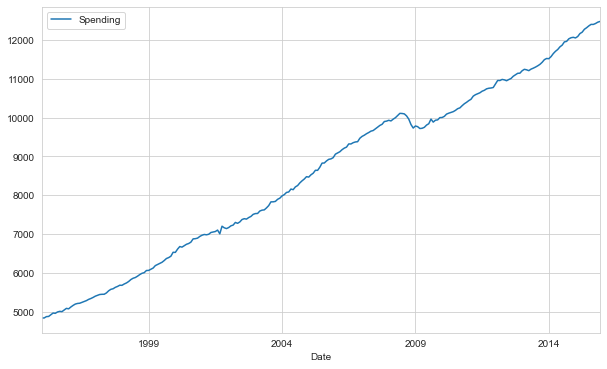

In [5]:
df.plot(figsize=(10,6))


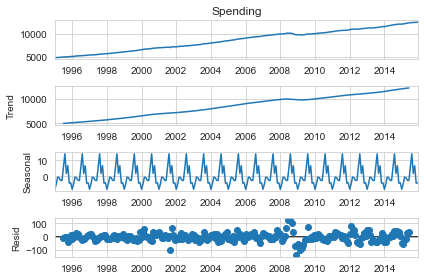

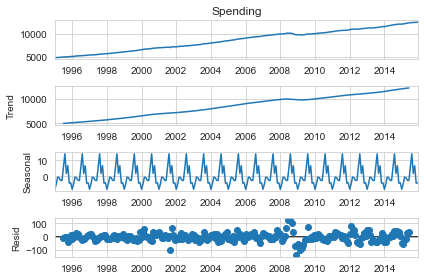

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df["Spending"], model="Additive")
results.plot()


In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print('Dickey-Fuller Test:')
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    print(out.to_string())
    print("*"*60)

    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
    else :
        print("Data has a unit root and is non-stationary")


In [8]:
adf_test(df)


Dickey-Fuller Test:
ADF test                  0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
************************************************************
Data has a unit root and is non-stationary


In [9]:
from pmdarima import auto_arima

result = auto_arima(df["Spending"], seasonal=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2489.265, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2491.179, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2493.109, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2493.123, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2634.224, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2487.202, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2490.649, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2488.774, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2489.179, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2489.688, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2487.240, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2496.732, Time=0.05 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.264 seconds


In [10]:
from statsmodels.tsa.arima.model import ARIMA

Train = df[:200]
Test = df[200:]

# Build the model
model = ARIMA(Train['Spending'], order=(1,1,2))

# Fit the model
result = model.fit()

# Predict the test data
start = len(Train)
end = len(df) - 1

pred = result.predict(start = start, end = end, type="levels", dynamic=False).rename("Predictions")


<AxesSubplot:xlabel='Date'>

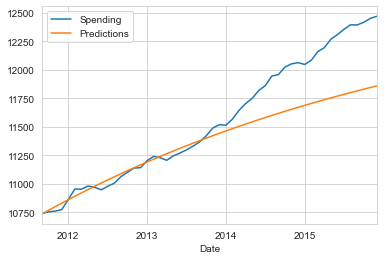

In [11]:
# Plot Prediction vs Test
Test["Spending"].plot(legend = True)
pred.plot(legend = True)


In [12]:
from statsmodels.tools.eval_measures import rmse

error = rmse(Test["Spending"], pred)
print(f'ARIMA(1,1,2) RMSE Error: {error:11.10}')


ARIMA(1,1,2) RMSE Error: 288.0945063


<AxesSubplot:xlabel='Date'>

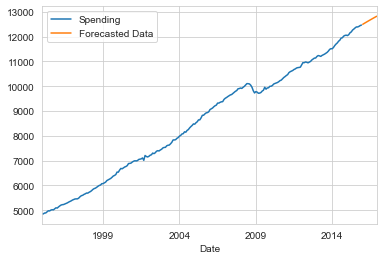

In [13]:
# Retrain the model on the whole dataset

model = ARIMA(df["Spending"], order=(1,1,2))
result = model.fit()

# forcast using the model
forecast = result.predict(start = len(df), end = len(df) + 11, type="levels", dynamic=False).rename("Forecasted Data")

df["Spending"].plot(legend=True)
forecast.plot(legend=True)
